In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

import os

## Data read

In [2]:
DATA_PATH = "./data/used_cars.csv"

In [3]:
data = pd.read_csv(DATA_PATH)

## Quick overview

In [4]:
data.head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"
5,Acura,ILX 2.4L,2016,"136,397 mi.",Gasoline,2.4 Liter,F,Silver,Ebony.,None reported,NaN,"$14,798"
6,Audi,S3 2.0T Premium Plus,2017,"84,000 mi.",Gasoline,292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,Blue,Black,None reported,Yes,"$31,000"
7,BMW,740 iL,2001,"242,000 mi.",Gasoline,282.0HP 4.4L 8 Cylinder Engine Gasoline Fuel,A/T,Green,Green,None reported,Yes,"$7,300"
8,Lexus,RC 350 F Sport,2021,"23,436 mi.",Gasoline,311.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,6-Speed A/T,Black,Black,None reported,Yes,"$41,927"
9,Tesla,Model X Long Range Plus,2020,"34,000 mi.",NaN,534.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,Yes,"$69,950"


In [5]:
data.isnull().sum()

brand             0
model             0
model_year        0
milage            0
fuel_type       170
engine            0
transmission      0
ext_col           0
int_col           0
accident        113
clean_title     596
price             0
dtype: int64

In [6]:
data.duplicated().sum()

0

In [7]:
data.nunique()

brand             57
model           1898
model_year        34
milage          2818
fuel_type          7
engine          1146
transmission      62
ext_col          319
int_col          156
accident           2
clean_title        1
price           1569
dtype: int64

In [8]:
print("Clean title unique: ", data.clean_title.unique())
print("Accident unique: ", data.accident.unique())
print("transmission unique: ", data.transmission.unique())
print("fuel_type unique: ", data.fuel_type.unique())

Clean title unique:  ['Yes' nan]
Accident unique:  ['At least 1 accident or damage reported' 'None reported' nan]
transmission unique:  ['6-Speed A/T' '8-Speed Automatic' 'Automatic' '7-Speed A/T' 'F' 'A/T'
 '8-Speed A/T' 'Transmission w/Dual Shift Mode' '9-Speed Automatic'
 '6-Speed M/T' '10-Speed A/T' '9-Speed A/T' '5-Speed A/T' '1-Speed A/T'
 'Automatic CVT' '7-Speed Automatic with Auto-Shift' 'CVT-F' 'M/T'
 '6-Speed Automatic with Auto-Shift' '10-Speed Automatic'
 'CVT Transmission' '4-Speed A/T' '6-Speed Automatic' '4-Speed Automatic'
 '7-Speed M/T' '8-Speed Automatic with Auto-Shift' '5-Speed Automatic'
 '8-SPEED AT' '1-Speed Automatic' '5-Speed M/T' 'Manual' '6-Speed Manual'
 'Variable' '2' '7-Speed Manual' 'Automatic, 9-Spd 9G-Tronic'
 'Automatic, 8-Spd' 'Automatic, 8-Spd Sport w/Sport & Manual Modes' '–'
 'Auto, 6-Spd w/CmdShft' 'Transmission Overdrive Switch'
 '7-Speed Automatic' 'Automatic, 8-Spd PDK Dual-Clutch'
 'Automatic, 8-Spd M STEPTRONIC w/Drivelogic, Sport & Manual M

## Initial cleaning 

### String cleaning

In [9]:
data.brand = data.brand.str.lower()
data.model = data.model.str.lower()
data.fuel_type = data.fuel_type.str.lower()
data.engine = data.engine.str.lower()
data.transmission = data.transmission.str.lower()
data.ext_col = data.ext_col.str.lower()
data.int_col = data.int_col.str.lower()
data.accident = data.accident.str.lower()
data.clean_title = data.clean_title.str.lower()

In [10]:
data.milage = data.milage.str.replace(',', '').str.extract('(\d+)').astype(float)
data.price = data.price.str.replace(',', '').str.extract('(\d+)').astype(float)

### Extracting features

In [11]:
def categorize_transmission(x):
    x = x.lower()
    if 'manual' in x or 'm/t' in x or '6 speed mt' in x or 'manual, 6-spd' in x:
        return 'manual'
    elif 'automatic' in x or 'a/t' in x or 'cvt' in x or 'auto' in x:
        return 'automatic'
    elif 'dual-clutch' in x or 'dct' in x:
        return 'dual_clutch'
    else:
        return 'automatic' 

In [12]:
data["transmission_category"] = data['transmission'].apply(categorize_transmission)

In [13]:
def enhance_dataframe_with_engine_info(df):
    hp_pattern = re.compile(r'(\d+\.?\d*)\s*hp', re.IGNORECASE)
    volume_pattern = re.compile(r'(\d+\.?\d*)\s*l', re.IGNORECASE)
    cylinder_pattern = re.compile(r'(\d+)\s*cylinder', re.IGNORECASE)
    v_cylinder_pattern = re.compile(r'V(\d+)', re.IGNORECASE)
    
    horsepower = []
    engine_volume_l = []
    cylinders = []
    
    for engine_str in df['engine']:
        hp_match = hp_pattern.search(engine_str)
        volume_match = volume_pattern.search(engine_str)
        cylinder_match = cylinder_pattern.search(engine_str)
        v_cylinder_match = v_cylinder_pattern.search(engine_str)
        
        if hp_match:
            horsepower.append(float(hp_match.group(1)))
        else:
            horsepower.append(None)
        
        if volume_match:
            engine_volume_l.append(float(volume_match.group(1)))
        else:
            engine_volume_l.append(None)
        
        if cylinder_match:
            cylinders.append(int(cylinder_match.group(1)))
        elif v_cylinder_match:
            cylinders.append(int(v_cylinder_match.group(1)))
        else:
            cylinders.append(None)

    df['horsepower'] = horsepower
    df['engine_volume_l'] = engine_volume_l
    df['cylinders'] = cylinders
    
    return df

In [14]:
data = enhance_dataframe_with_engine_info(data)

In [15]:
data.accident = data.accident.map({"at least 1 accident or damage reported" : 1, "none reported": 0})

### Cleaning features 

In [16]:
data.isnull().sum()

brand                      0
model                      0
model_year                 0
milage                     0
fuel_type                170
engine                     0
transmission               0
ext_col                    0
int_col                    0
accident                 113
clean_title              596
price                      0
transmission_category      0
horsepower               808
engine_volume_l          217
cylinders                622
dtype: int64

In [17]:
def fill_missing_horsepower(df):

    median_hp = df['horsepower'].median()
    median_volume = df['engine_volume_l'].median()
    hp_per_liter = median_hp / median_volume if median_volume else 0
    
    for index, row in df.iterrows():
        if pd.isna(row['horsepower']):
            if not pd.isna(row['engine_volume_l']):
                df.at[index, 'horsepower'] = row['engine_volume_l'] * hp_per_liter
            else:
                brand_median = df[df['brand'] == row['brand']]['horsepower'].median()
                if pd.notna(brand_median):
                    df.at[index, 'horsepower'] = brand_median
                else:
                    df.at[index, 'horsepower'] = median_hp
        

    return df

def fill_missing_fuel_types(df):
    most_common_fuel_by_brand = df.groupby('brand')['fuel_type'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    def fill_fuel_type(row):
        if pd.isnull(row['fuel_type']) or row['fuel_type'] == '–' :
            return most_common_fuel_by_brand[row['brand']]
        else:
            return row['fuel_type']
            
    df.fuel_type = df.apply(fill_fuel_type, axis=1)
    df.fuel_type = df.fuel_type.replace("not supported", "hydrogen")
    df.fuel_type = df.fuel_type.fillna("electric")
    return df


In [18]:
data = fill_missing_horsepower(data)
data = fill_missing_fuel_types(data)

/home/mkapala/Documents/WSI/venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [19]:
data.accident = data.accident.fillna(data.accident.mode()[0])

In [20]:
data = data.drop(['model','clean_title', "transmission", "engine","engine_volume_l", "ext_col", "int_col" , "cylinders"],axis=1,errors='ignore')

In [21]:
data.isnull().sum()

brand                    0
model_year               0
milage                   0
fuel_type                0
accident                 0
price                    0
transmission_category    0
horsepower               0
dtype: int64

## Data analysis

In [22]:
data.sample(10)

,brand,model_year,milage,fuel_type,accident,price,transmission_category,horsepower
2653,land,2020,57785.0,hybrid,0.0,63995.0,automatic,395.000000
760,ford,2022,15600.0,gasoline,1.0,68995.0,automatic,315.000000
859,lexus,2009,178000.0,gasoline,1.0,4500.0,automatic,270.000000
3020,ford,2010,232000.0,gasoline,0.0,3000.0,automatic,292.000000
1908,bentley,2016,31500.0,gasoline,0.0,103900.0,automatic,521.000000
3255,bmw,2015,26000.0,gasoline,0.0,14999.0,automatic,170.000000
673,porsche,2010,63000.0,gasoline,1.0,38500.0,automatic,500.000000
323,kia,2023,459.0,gasoline,0.0,36998.0,automatic,221.428571
3803,mercedes-benz,2022,18815.0,gasoline,0.0,61998.0,automatic,177.142857
834,ford,2021,48000.0,e85 flex fuel,0.0,57000.0,automatic,275.000000


In [23]:
data.describe()

,model_year,milage,accident,price,horsepower
count,4009.000000,4009.000000,4009.000000,4.009000e+03,4009.000000
mean,2015.515590,64717.551010,0.245947,4.455319e+04,328.470887
std,6.104816,52296.599459,0.430701,7.871064e+04,122.138198
min,1974.000000,100.000000,0.000000,2.000000e+03,70.000000
25%,2012.000000,23044.000000,0.000000,1.720000e+04,240.000000
50%,2017.000000,52775.000000,0.000000,3.100000e+04,310.000000
75%,2020.000000,94100.000000,0.000000,4.999000e+04,400.000000
max,2024.000000,405000.000000,1.000000,2.954083e+06,1020.000000


array([[<Axes: title={'center': 'model_year'}>,
        <Axes: title={'center': 'milage'}>],
       [<Axes: title={'center': 'accident'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'horsepower'}>, <Axes: >]], dtype=object)

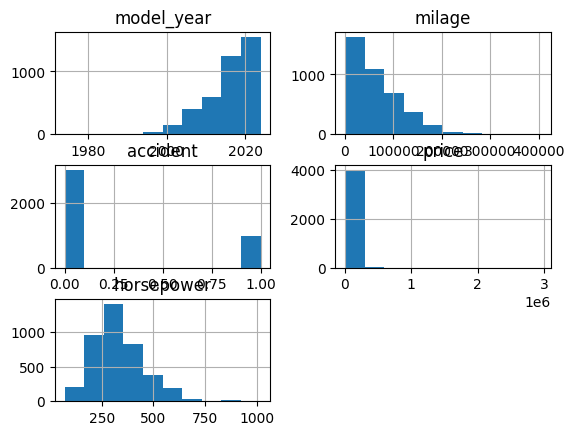

In [24]:
data.hist()

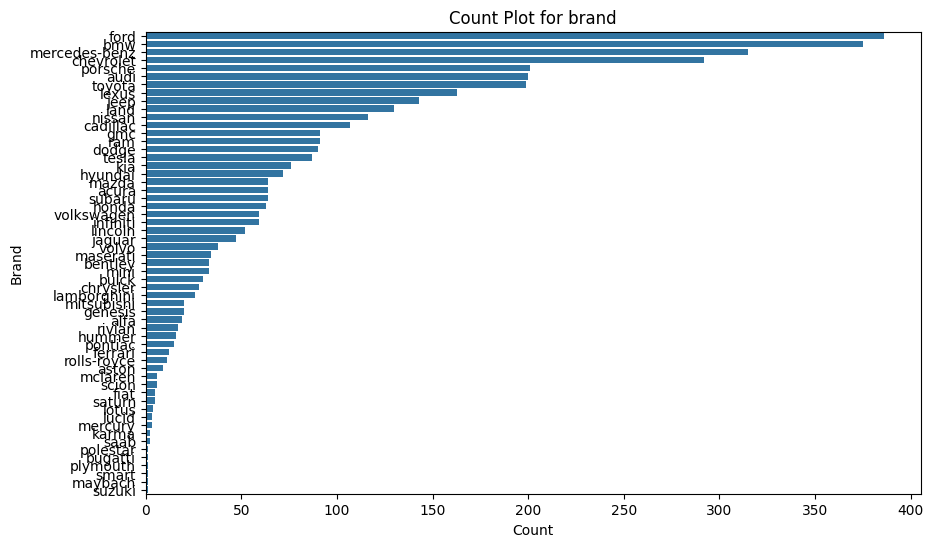

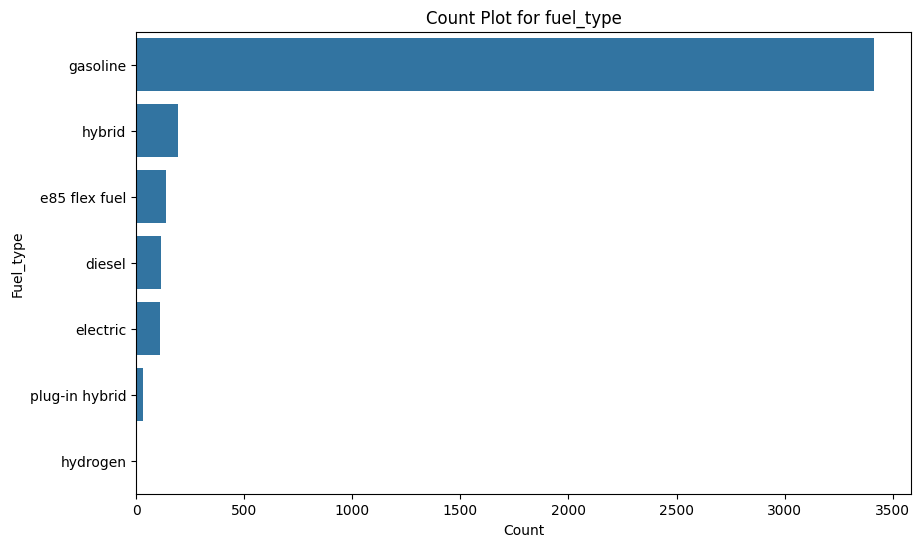

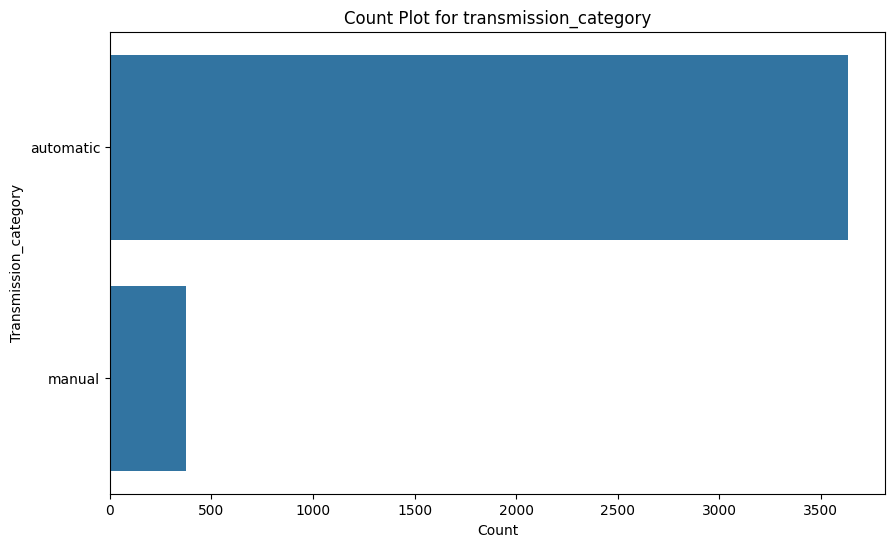

In [25]:
categorical_columns = ['brand', 'fuel_type', 'transmission_category']

for column in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=data, order = data[column].value_counts().index)
    plt.title(f'Count Plot for {column}')
    plt.xlabel('Count')
    plt.ylabel(column.capitalize())
    plt.show()

## Data encoding 

In [26]:
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

In [27]:
data.sample(10)

,model_year,milage,accident,price,horsepower,brand_alfa,brand_aston,brand_audi,brand_bentley,brand_bmw,...,brand_toyota,brand_volkswagen,brand_volvo,fuel_type_e85 flex fuel,fuel_type_electric,fuel_type_gasoline,fuel_type_hybrid,fuel_type_hydrogen,fuel_type_plug-in hybrid,transmission_category_manual
2054,2019,81301.0,0.0,30275.0,310.0,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
3246,2013,111000.0,1.0,15000.0,375.0,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
982,2023,8200.0,0.0,78900.0,437.0,False,False,False,False,False,...,True,False,False,False,False,False,True,False,False,False
1097,2015,76296.0,1.0,9500.0,182.0,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1517,2021,11250.0,0.0,70250.0,420.0,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3040,2011,195500.0,0.0,8999.0,310.0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2256,2015,17900.0,0.0,59900.0,560.0,False,False,False,False,True,...,False,False,False,False,False,True,False,False,False,False
3234,2015,122770.0,0.0,27499.0,360.0,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
772,2017,92000.0,0.0,20900.0,390.0,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
1825,2018,50000.0,0.0,27500.0,280.0,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [28]:
data.to_csv("./data/cleaned_car_data.csv")